In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils

from torch.optim import lr_scheduler
from torchvision import models

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(torch.__version__)

0.4.1


In [3]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

## 1. Neural Network Architecture

### Load Data

In [4]:
mnist_train = datasets.MNIST(root='data/', 
                             train=True,
                             transform=transforms.ToTensor(),
                             download=True)

mnist_test = datasets.MNIST(root='data/',
                            train=False,
                            transform=transforms.ToTensor(),
                            download=True)

In [5]:
mnist_train.train_data.size(), mnist_test.test_data.size()

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [6]:
batch_size = 100

data_loader = data.DataLoader(dataset = mnist_train,
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers = 0)

### Define Model

In [7]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        
        self.fc_layer = nn.Sequential(
            nn.Linear(784, 512, bias = True),
            nn.ReLU(),
            nn.Linear(512, 256, bias = True),
            nn.ReLU(),
            nn.Linear(256, 10, bias = True)
        )
        
    def forward(self, x):
        out = self.fc_layer(x)

        return out
    
model = DNN()
if is_cuda:
    model = DNN().cuda() 
    
loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01)

### Training

In [8]:
num_epochs = 5
if is_cuda:
    num_epochs = 10

for epoch in range(num_epochs):
    
    total_batch = len(mnist_train) // batch_size   # 60000 / 100 = 600
    
    for i, (batch_images, batch_labels) in enumerate(data_loader):

        X = batch_images.view(-1, 28 * 28)  # flatten
        Y = batch_labels
        if is_cuda:
            X = batch_images.view(-1, 28 * 28).cuda()
            Y = batch_labels.cuda()
        
        pred = model(X)
        cost = loss(pred, Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) % total_batch == 0:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'%(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    
print("Learning Finished!")

Epoch [1/10], lter [600/600] Loss: 0.1112
Epoch [2/10], lter [600/600] Loss: 0.0628
Epoch [3/10], lter [600/600] Loss: 0.0260
Epoch [4/10], lter [600/600] Loss: 0.0476
Epoch [5/10], lter [600/600] Loss: 0.1145
Epoch [6/10], lter [600/600] Loss: 0.0570
Epoch [7/10], lter [600/600] Loss: 0.0300
Epoch [8/10], lter [600/600] Loss: 0.0607
Epoch [9/10], lter [600/600] Loss: 0.0039
Epoch [10/10], lter [600/600] Loss: 0.0009
Learning Finished!


### Test

In [9]:
model.eval()

correct = 0
total = 0

for images, labels in mnist_test:
    
    X = images.view(-1, 28 * 28)
    if is_cuda:
        X = images.view(-1, 28 * 28).cuda()
    
    outputs = model(X)
    
    _, pred = torch.max(outputs.data, 1)  # arg max
    
    total += 1
    if is_cuda:
        correct += (pred == labels.cuda()).sum()
    else:
        correct += (pred == labels).sum()
        
print('correct :', correct.cpu().numpy())
print('total   :', total)
print('Accuracy of test images: %f' % (100 * correct.cpu().numpy() / total))

correct : 9823
total   : 10000
Accuracy of test images: 98.230000


-----------

## Loss Function

* L1 loss : Mostly used as a regularizer. 
* MSE loss : Used as loss function for regression problems.
* Cross-entropy loss : Used for binary and multi-class classification problems.
* NLL Loss : Used for classification problems and allows us to use specific weights to handle imbalanced datasets.
* NLL Loss2d : Used for pixel-wise classification, mostly for problems related to image segmentation.

--------

## 2. Cats and Dogs Classification

https://www.kaggle.com/c/dogs-vs-cats/data

### Load data

In [10]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])      # 0 ~ 1 사이로 normalization
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

batch_size = 10

train_data = datasets.ImageFolder('data/catsdogs/train/', train_transform)
test_data = datasets.ImageFolder('data/catsdogs/test/', test_transform)

train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

In [11]:
print(train_data.class_to_idx)
print(train_data.classes)

{'cat': 0, 'dog': 1}
['cat', 'dog']


In [12]:
print(len(train_data), len(test_data))

20000 5000


### Check data

In [13]:
def imshow(img):
    npimg = img.numpy()
    fig = plt.figure(figsize = (15, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

torch.Size([10, 3, 224, 224])


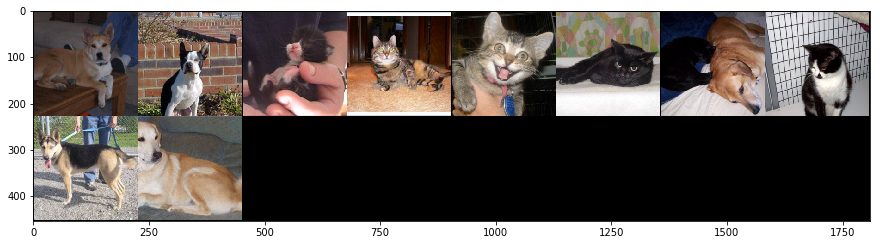

In [14]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.size())

imshow(utils.make_grid(images, normalize=True))

### Define model : Transfer learning

In [15]:
model = models.resnet18(pretrained=True)

print('no of features :', model.fc.in_features)

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 10),
#     nn.Linear(256, 10),
    nn.Linear(10, 2)
)

if is_cuda:
    model = model.cuda()

no of features : 512


In [16]:
loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# dynamically change the learning rate.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

### Training

In [17]:
def train_model(model, loss, optimizer, scheduler, num_epochs=10):

    for epoch in range(num_epochs):

        scheduler.step()
        
        batch_count = len(train_data)//batch_size

        for i, (batch_images, batch_labels) in enumerate(train_loader):

            X = batch_images
            Y = batch_labels
            if is_cuda:
                X = batch_images.cuda()
                Y = batch_labels.cuda()

            pred = model(X)
            cost = loss(pred, Y)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            if (i+1) % 200 == 0:
                print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f' % (epoch+1, num_epochs, i+1, batch_count, cost.item()))

In [18]:
if is_cuda:
    train_model(model, loss, optimizer, exp_lr_scheduler, 3)
else:
    train_model(model, loss, optimizer, exp_lr_scheduler, 1)
    
print("Learning Finished!")

Epoch [1/3], lter [200/2000] Loss: 0.3640
Epoch [1/3], lter [400/2000] Loss: 0.4171
Epoch [1/3], lter [600/2000] Loss: 0.1935
Epoch [1/3], lter [800/2000] Loss: 0.0935
Epoch [1/3], lter [1000/2000] Loss: 0.0874
Epoch [1/3], lter [1200/2000] Loss: 0.1737
Epoch [1/3], lter [1400/2000] Loss: 0.1207
Epoch [1/3], lter [1600/2000] Loss: 0.1162
Epoch [1/3], lter [1800/2000] Loss: 0.4898
Epoch [1/3], lter [2000/2000] Loss: 0.0431
Epoch [2/3], lter [200/2000] Loss: 0.3741
Epoch [2/3], lter [400/2000] Loss: 1.0353
Epoch [2/3], lter [600/2000] Loss: 0.2601
Epoch [2/3], lter [800/2000] Loss: 0.3257
Epoch [2/3], lter [1000/2000] Loss: 0.0971
Epoch [2/3], lter [1200/2000] Loss: 0.1274
Epoch [2/3], lter [1400/2000] Loss: 0.3924
Epoch [2/3], lter [1600/2000] Loss: 0.2303
Epoch [2/3], lter [1800/2000] Loss: 0.1847
Epoch [2/3], lter [2000/2000] Loss: 0.1214
Epoch [3/3], lter [200/2000] Loss: 0.3155
Epoch [3/3], lter [400/2000] Loss: 0.0060
Epoch [3/3], lter [600/2000] Loss: 0.2881
Epoch [3/3], lter [800

### Test

In [19]:
model.eval()

correct = 0
total = 0

for i, (batch_images, batch_labels) in enumerate(test_loader):
    
    X = batch_images
    if is_cuda:
        X = batch_images.cuda()
        
    outputs = model(X)
    
    _, pred = torch.max(outputs.data, 1)  # arg max
    
    total += batch_labels.size(0)
    if is_cuda:
        correct += (pred == batch_labels.cuda()).sum()
    else:
        correct += (pred == batch_labels).sum()
        
print('correct :', correct.cpu().numpy())
print('total   :', total)
print('Accuracy of test images: %f' % (100 * correct.cpu().numpy() / total))

correct : 4711
total   : 5000
Accuracy of test images: 94.220000
